In [53]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[1] "dataset-quantium"

In [54]:
library(data.table) 
library(ggplot2)
library(ggmosaic)
library(readr)

In [55]:
TransactionData <- fread("/kaggle/input/dataset-quantium/QVI_transaction_data - in.csv")
CustomerData <- fread("/kaggle/input/dataset-quantium/QVI_purchase_behaviour.csv")

# Cleaning Transaction data

I will sart formatting the dataset properly, adjusting the Date and Product Name colunms. The next steps will be check for nulls, missing data and outliers.

In [56]:
TransactionData$DATE <- as.Date(TransactionData$DATE, origin= "1899-12-30")

In [57]:
##figure out how many different chips are in this dataset
length(unique(TransactionData$PROD_NAME))

[1] 114

In [58]:
library(dplyr)
## Separating the chip size from the chips name
TransactionData <- TransactionData %>%
mutate(Pack_Size = as.numeric(str_extract(PROD_NAME,"\\d+")),
      product_name = str_remove(PROD_NAME,"\\s*\\d+g$")) 
head(TransactionData)
       

DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,Pack_Size,product_name
<date>,<int>,<int>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>
2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural Chip Compny SeaSalt
2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCs Nacho Cheese
2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smiths Crinkle Cut Chips Chicken
2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smiths Chip Thinly S/Cream&Onion
2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle Tortilla ChpsHny&Jlpno Chili
2019-05-19,4,4074,2982,57,Old El Paso Salsa Dip Tomato Mild 300g,1,5.1,300,Old El Paso Salsa Dip Tomato Mild


In [59]:
TransactionData <- TransactionData %>%
select(-PROD_NAME)

In [60]:

productWords <- data.table(unlist(strsplit(unique(TransactionData[,product_name ]), " "))) 
setnames(productWords, 'words')

##Removing digits and special characters
productWords$words <- gsub("[^A-Za-z ]", "",productWords$words)
##Removing blank rows
productWords <- productWords[words != "", ]

In [61]:
##Removing salsa words
TransactionData[, SALSA := grepl("salsa", tolower(product_name))] 
TransactionData <- TransactionData[SALSA == FALSE, ][, SALSA := NULL]

In [62]:
##Figuring out the top 10 most common words
WordCounts <- productWords %>%
  count(words, sort = TRUE)
head(WordCounts, 10)

words,n
<chr>,<int>
Chips,21
Smiths,16
Crinkle,14
Cut,14
Kettle,13
Cheese,12
Salt,12
Original,10
Chip,9


In [63]:
summary(TransactionData)

      DATE              STORE_NBR     LYLTY_CARD_NBR        TXN_ID       
 Min.   :2018-07-01   Min.   :  1.0   Min.   :   1000   Min.   :      1  
 1st Qu.:2018-09-30   1st Qu.: 70.0   1st Qu.:  70015   1st Qu.:  67569  
 Median :2018-12-30   Median :130.0   Median : 130367   Median : 135183  
 Mean   :2018-12-30   Mean   :135.1   Mean   : 135531   Mean   : 135131  
 3rd Qu.:2019-03-31   3rd Qu.:203.0   3rd Qu.: 203084   3rd Qu.: 202654  
 Max.   :2019-06-30   Max.   :272.0   Max.   :2373711   Max.   :2415841  
    PROD_NBR         PROD_QTY         TOT_SALES         Pack_Size    
 Min.   :  1.00   Min.   :  1.000   Min.   :  1.700   Min.   : 70.0  
 1st Qu.: 26.00   1st Qu.:  2.000   1st Qu.:  5.800   1st Qu.:150.0  
 Median : 53.00   Median :  2.000   Median :  7.400   Median :170.0  
 Mean   : 56.35   Mean   :  1.908   Mean   :  7.321   Mean   :175.6  
 3rd Qu.: 87.00   3rd Qu.:  2.000   3rd Qu.:  8.800   3rd Qu.:175.0  
 Max.   :114.00   Max.   :200.000   Max.   :650.000   Max.   :

In [64]:
##Investigating outliers in PROD_QTY 
FilterData <- TransactionData [PROD_QTY == 200.000 ]
##Filtering the data we can see that both maximum product quantity and total sales were caused by the same customer
##So I will analyze other transactions made with the same LYLTY_CARD_NBR 

In [65]:
FilterData <- TransactionData[LYLTY_CARD_NBR == 226000]

In [66]:
##The customer just made two transaction in one year, so I will remove this LYLTY_CARD_NBR 
TransactionData <- TransactionData %>%
  filter(LYLTY_CARD_NBR != 226000)

In [67]:
summary(TransactionData)

      DATE              STORE_NBR     LYLTY_CARD_NBR        TXN_ID       
 Min.   :2018-07-01   Min.   :  1.0   Min.   :   1000   Min.   :      1  
 1st Qu.:2018-09-30   1st Qu.: 70.0   1st Qu.:  70015   1st Qu.:  67569  
 Median :2018-12-30   Median :130.0   Median : 130367   Median : 135182  
 Mean   :2018-12-30   Mean   :135.1   Mean   : 135530   Mean   : 135130  
 3rd Qu.:2019-03-31   3rd Qu.:203.0   3rd Qu.: 203083   3rd Qu.: 202652  
 Max.   :2019-06-30   Max.   :272.0   Max.   :2373711   Max.   :2415841  
    PROD_NBR         PROD_QTY       TOT_SALES        Pack_Size    
 Min.   :  1.00   Min.   :1.000   Min.   : 1.700   Min.   : 70.0  
 1st Qu.: 26.00   1st Qu.:2.000   1st Qu.: 5.800   1st Qu.:150.0  
 Median : 53.00   Median :2.000   Median : 7.400   Median :170.0  
 Mean   : 56.35   Mean   :1.906   Mean   : 7.316   Mean   :175.6  
 3rd Qu.: 87.00   3rd Qu.:2.000   3rd Qu.: 8.800   3rd Qu.:175.0  
 Max.   :114.00   Max.   :5.000   Max.   :29.500   Max.   :380.0  
 product_name

In [68]:
##Now we will check for missing data analyzing the count of date colunm.
Transaction_Count <- TransactionData %>%
summarise(NumberOfDays= n_distinct(DATE))
head(Transaction_Count)

,NumberOfDays
,<int>
1,364


In [69]:
##Finding and correcting the missing day
all_dates <- data.frame(DATE= seq.Date(from=as.Date("2018-07-01"),
                                     to= as.Date("2019-06-30"),
                                     by= "day"))
Transaction_Count_ByDay <- TransactionData %>%
count(DATE)

Transaction_by_day <- all_dates %>%
left_join(Transaction_Count_ByDay,by="DATE")
head(Transaction_by_day)

,DATE,n
,<date>,<int>
1,2018-07-01,663
2,2018-07-02,650
3,2018-07-03,674
4,2018-07-04,669
5,2018-07-05,660
6,2018-07-06,711


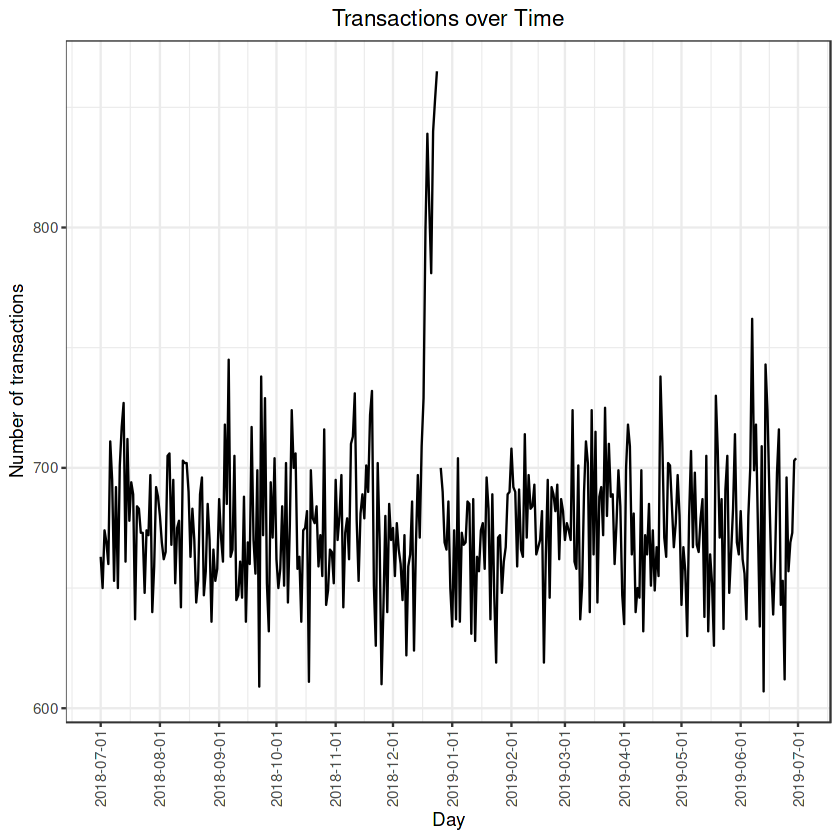

In [70]:
#### Setting plot themes to format graphs 
theme_set(theme_bw()) 
theme_update(plot.title = element_text(hjust = 0.5))
#### Plot transactions over time
ggplot(data=Transaction_by_day)+ geom_line(mapping= aes(x=DATE,y=n))+
scale_x_date (breaks="1 month")+ 
labs(x = "Day", y = "Number of transactions", title = "Transactions over Time")+
theme(axis.text.x=element_text(angle=90,vjust=0.5))


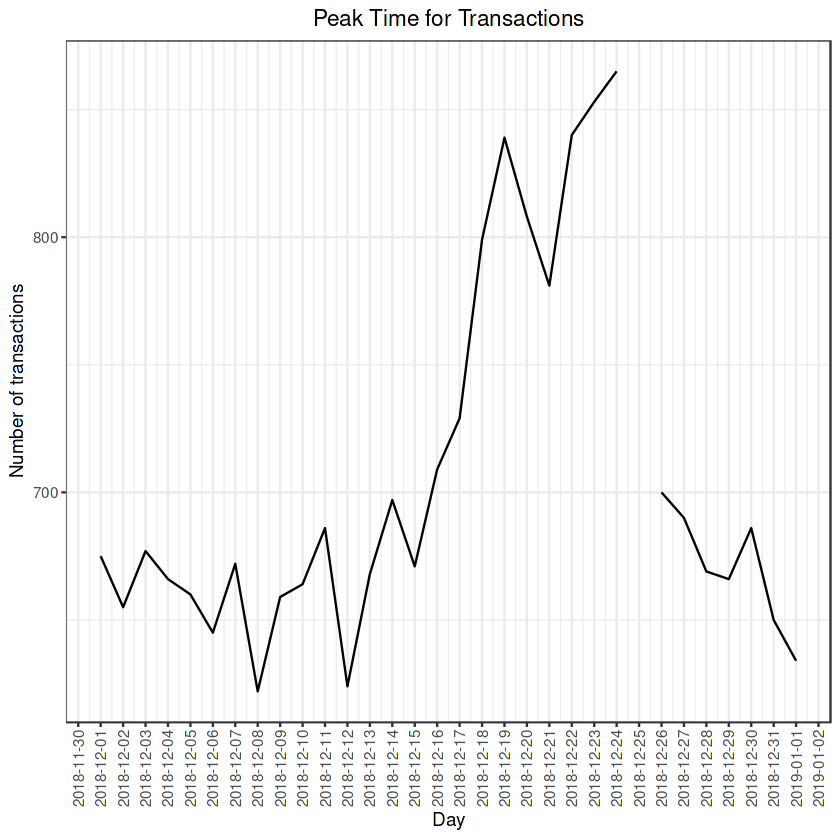

In [71]:
#### Plot transactions in december
ggplot(subset(Transaction_by_day, DATE >="2018-12-01" & DATE <= "2019-01-01"),aes(x = DATE,y= n)) + 
geom_line() + 
labs(x = "Day", y = "Number of transactions", title = "Peak Time for Transactions") + 
scale_x_date(breaks = "1 day") + theme(axis.text.x = element_text(angle = 90, vjust = 0.5))

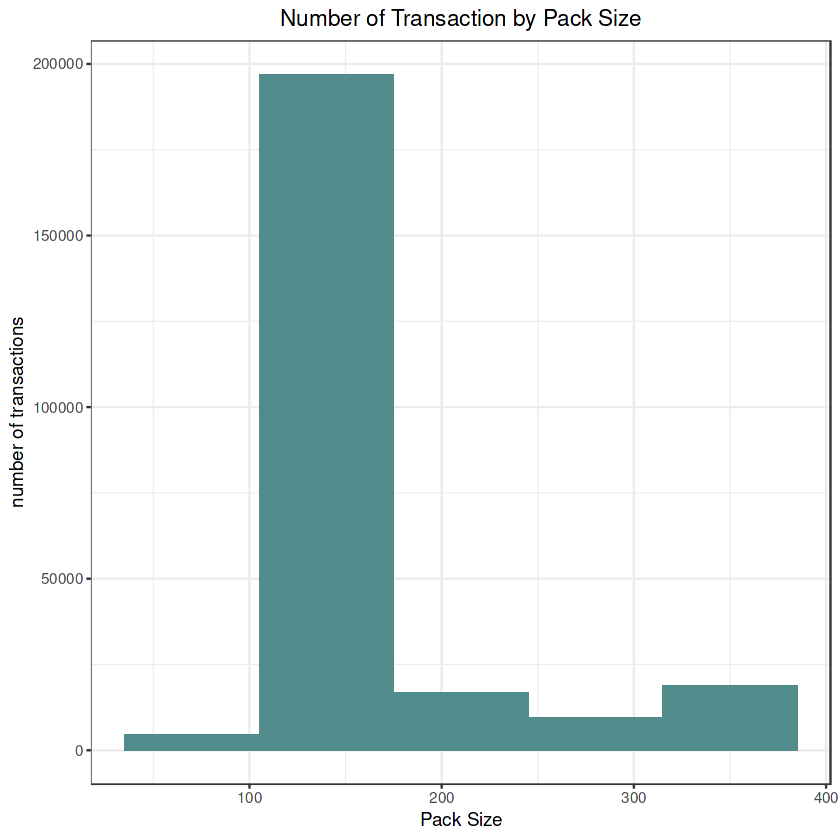

In [72]:
##Creating a histogram showing the number of transaction by pack size
ggplot(TransactionData, aes(x=Pack_Size))+geom_histogram(binwidth=70,fill= "#528B8B")+ 
labs(title="Number of Transaction by Pack Size", x= "Pack Size", y= "number of transactions")

In [73]:
##Extracting the brand from the product name colunm 
TransactionData <- TransactionData %>%
mutate(Brand= str_extract(product_name,"^\\S+"))
head(TransactionData)

DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES,Pack_Size,product_name,Brand
<date>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>
2018-10-17,1,1000,1,5,2,6.0,175,Natural Chip Compny SeaSalt,Natural
2019-05-14,1,1307,348,66,3,6.3,175,CCs Nacho Cheese,CCs
2019-05-20,1,1343,383,61,2,2.9,170,Smiths Crinkle Cut Chips Chicken,Smiths
2018-08-17,2,2373,974,69,5,15.0,175,Smiths Chip Thinly S/Cream&Onion,Smiths
2018-08-18,2,2426,1038,108,3,13.8,150,Kettle Tortilla ChpsHny&Jlpno Chili,Kettle
2019-05-16,4,4149,3333,16,1,5.7,330,Smiths Crinkle Chips Salt & Vinegar,Smiths


In [74]:
##Cleaning Brand colunm
chekingTypos <- unique(TransactionData$Brand)
View(chekingTypos)


[1] "Natural"    "CCs"        "Smiths"     "Kettle"     "Grain"     
 [6] "Doritos"    "Twisties"   "WW"         "Thins"      "Burger"    
[11] "NCC"        "Cheezels"   "Infzns"     "Red"        "Pringles"  
[16] "Dorito"     "Infuzions"  "Smith"      "GrnWves"    "Tyrrells"  
[21] "Cobs"       "French"     "RRD"        "Tostitos"   "Cheetos"   
[26] "Woolworths" "Snbts"      "Sunbites"

In [75]:
TransactionData <- TransactionData %>%
mutate(Brand= case_when(
    Brand== "RRD" ~ "Red",
    Brand== "Snbts" ~ "Sunbites",
    Brand== "Infzns" ~ "Infuzions",
    Brand== "Smith" ~ "Smiths",
    Brand== "Dorito" ~ "Doritos",
 TRUE ~ Brand ))

# Exploratory data analysis of customer data


In [76]:
head(CustomerData)

LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
<int>,<chr>,<chr>
1000,YOUNG SINGLES/COUPLES,Premium
1002,YOUNG SINGLES/COUPLES,Mainstream
1003,YOUNG FAMILIES,Budget
1004,OLDER SINGLES/COUPLES,Mainstream
1005,MIDAGE SINGLES/COUPLES,Mainstream
1007,YOUNG SINGLES/COUPLES,Budget


In [77]:
unique(CustomerData[, .(LIFESTAGE )])
unique (CustomerData[,.(PREMIUM_CUSTOMER)])

LIFESTAGE
<chr>
YOUNG SINGLES/COUPLES
YOUNG FAMILIES
OLDER SINGLES/COUPLES
MIDAGE SINGLES/COUPLES
NEW FAMILIES
OLDER FAMILIES
RETIREES


PREMIUM_CUSTOMER
<chr>
Premium
Mainstream
Budget


In [78]:
CustomerData %>%
count(LIFESTAGE,sort= TRUE)

LIFESTAGE,n
<chr>,<int>
RETIREES,14805
OLDER SINGLES/COUPLES,14609
YOUNG SINGLES/COUPLES,14441
OLDER FAMILIES,9780
YOUNG FAMILIES,9178
MIDAGE SINGLES/COUPLES,7275
NEW FAMILIES,2549


In [79]:
CustomerData %>%
count(PREMIUM_CUSTOMER,sort= TRUE)

PREMIUM_CUSTOMER,n
<chr>,<int>
Mainstream,29245
Budget,24470
Premium,18922


####  Insights from this analyze: 
1. Majority of customers are retirees.
2. The single or couples consume more than families and betwenn this group the olders are the majority. 
3. The premium customers are the least popular among the three types of customers.

In [80]:
##detecting if there are unusually long/short entries
summary(nchar(CustomerData$PREMIUM_CUSTOMER))
summary(nchar(CustomerData$LIFESTAGE))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  6.000   6.000   7.000   7.871  10.000  10.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   8.00   14.00   21.00   16.31   21.00   22.00 

In [81]:
##Checking for missing values
sum(is.na(CustomerData))

[1] 0

#### Merging datasets

After verify if the data is clean and made some basica summaries analyzes the customer dataset is ready to be merged with transaction data.

In [82]:
Data <- merge(TransactionData, CustomerData, all.x=TRUE)
head(Data)

LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES,Pack_Size,product_name,Brand,LIFESTAGE,PREMIUM_CUSTOMER
<int>,<date>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1000,2018-10-17,1,1,5,2,6.0,175,Natural Chip Compny SeaSalt,Natural,YOUNG SINGLES/COUPLES,Premium
1002,2018-09-16,1,2,58,1,2.7,150,Red Rock Deli Chikn&Garlic Aioli,Red,YOUNG SINGLES/COUPLES,Mainstream
1003,2019-03-07,1,3,52,1,3.6,210,Grain Waves Sour Cream&Chives 210G,Grain,YOUNG FAMILIES,Budget
1003,2019-03-08,1,4,106,1,3.0,175,Natural ChipCo Hony Soy Chckn,Natural,YOUNG FAMILIES,Budget
1004,2018-11-02,1,5,96,1,1.9,160,WW Original Stacked Chips,WW,OLDER SINGLES/COUPLES,Mainstream
1005,2018-12-28,1,6,86,1,2.8,165,Cheetos Puffs,Cheetos,MIDAGE SINGLES/COUPLES,Mainstream


In [83]:
##Checking for missing values
sum(is.na(Data))

[1] 0

In [84]:
fwrite(Data, "QVI_Data.csv")


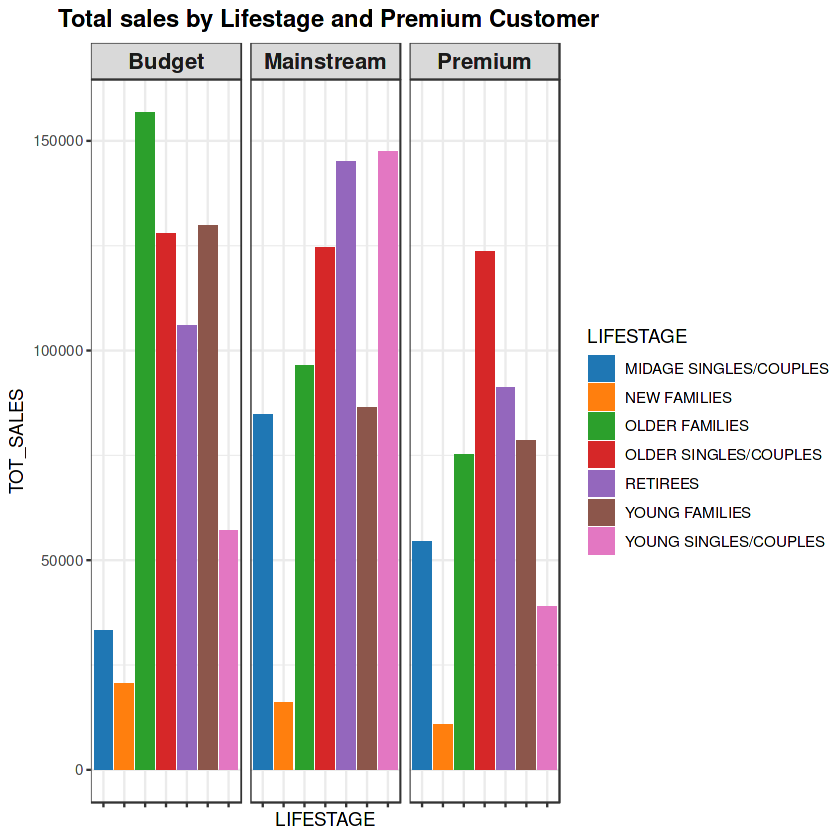

In [85]:
## Now we can create some visualizations based on the merged dataset to present some insights
ggplot(data=Data)+geom_col(mapping= aes(x=LIFESTAGE,y=TOT_SALES,fill=LIFESTAGE)) +
facet_wrap(~PREMIUM_CUSTOMER)+
theme( axis.text.x=element_blank(),
      plot.title=element_text(size=14,face= "bold",hjust=0.5),
     strip.text=element_text(size = 13, face = "bold")) + 
 scale_fill_manual(values = c(
    "MIDAGE SINGLES/COUPLES" = "#1f77b4",
    "NEW FAMILIES" = "#ff7f0e",
    "OLDER FAMILIES" = "#2ca02c",
    "OLDER SINGLES/COUPLES" = "#d62728",
    "RETIREES" = "#9467bd",
    "YOUNG FAMILIES" = "#8c564b",
    "YOUNG SINGLES/COUPLES" = "#e377c2"
  ))+
labs(title=" Total sales by Lifestage and Premium Customer")

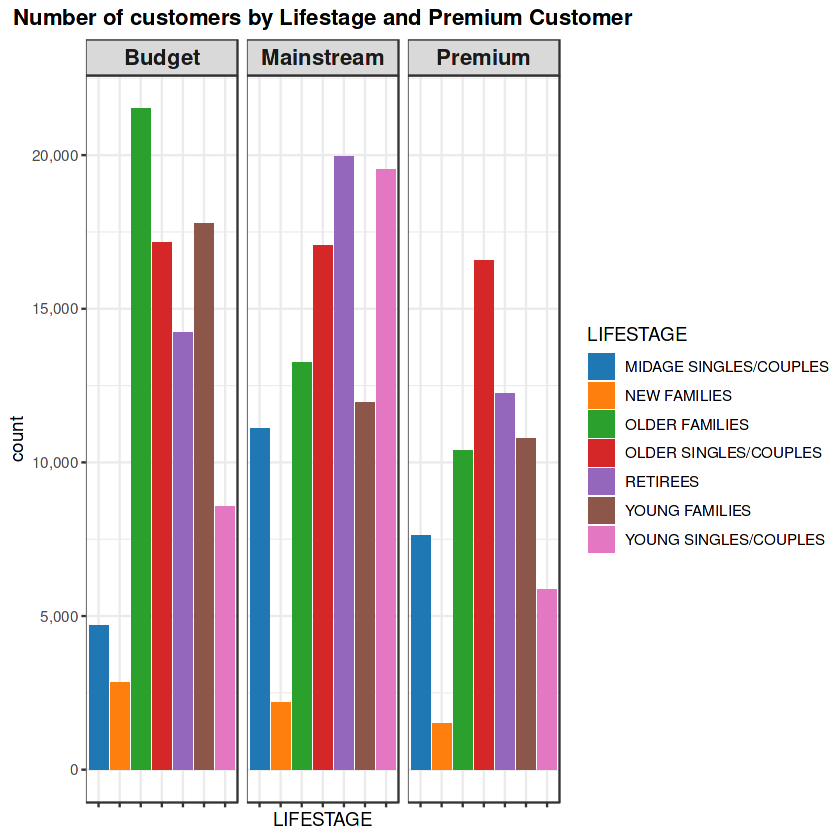

In [86]:
ggplot(data=Data)+geom_bar(mapping=aes(x=LIFESTAGE,fill=LIFESTAGE))+
facet_wrap(~PREMIUM_CUSTOMER)+
scale_y_continuous(labels=scales::label_comma())+
theme(  plot.title=element_text(size=13,face= "bold",hjust=0.5),
     strip.text=element_text(size = 13, face = "bold"),
    axis.text.x=element_blank(),
     ) + 
 scale_fill_manual(values = c(
    "MIDAGE SINGLES/COUPLES" = "#1f77b4",
    "NEW FAMILIES" = "#ff7f0e",
    "OLDER FAMILIES" = "#2ca02c",
    "OLDER SINGLES/COUPLES" = "#d62728",
    "RETIREES" = "#9467bd",
    "YOUNG FAMILIES" = "#8c564b",
    "YOUNG SINGLES/COUPLES" = "#e377c2"
  ))+
labs(title="Number of customers by Lifestage and Premium Customer")

In [87]:
UnitsPerCustomer <- Data %>%
group_by(LIFESTAGE,PREMIUM_CUSTOMER)%>%
summarise(AverageUnits=mean(PROD_QTY))


`summarise()` has grouped output by 'LIFESTAGE'. You can override using the
`.groups` argument.


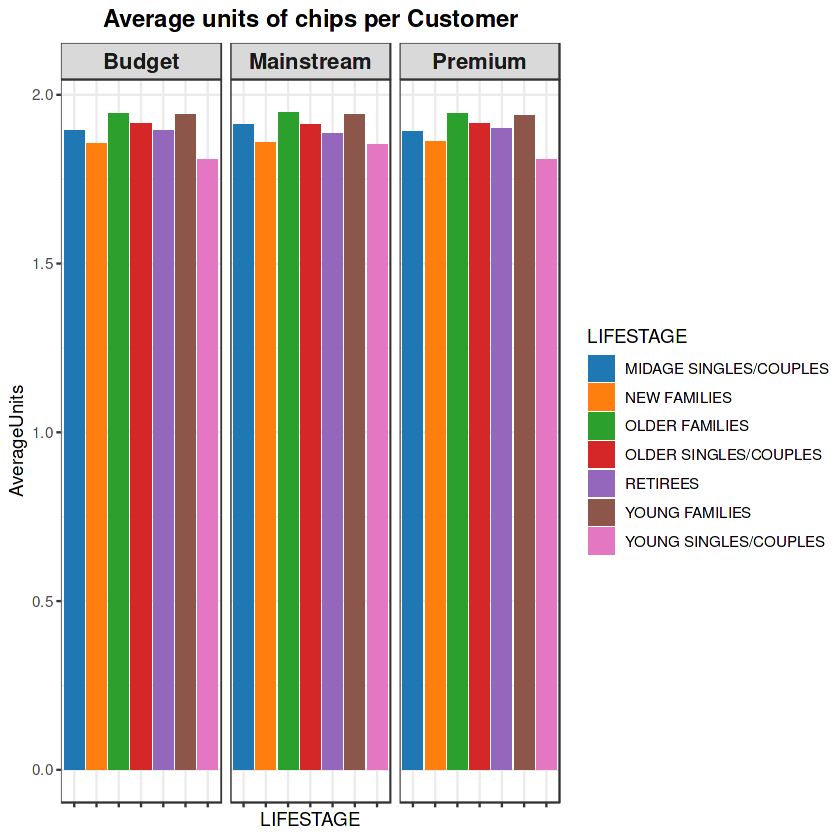

In [88]:
ggplot(UnitsPerCustomer,aes(x=LIFESTAGE,y=AverageUnits,fill=LIFESTAGE))+
geom_col ()+
facet_wrap(~PREMIUM_CUSTOMER)+
scale_y_continuous(labels=scales::label_comma())+
theme(  plot.title=element_text(size=14,face= "bold",hjust=0.5),
     strip.text=element_text(size = 13, face = "bold"),
    axis.text.x=element_blank()) + 
scale_fill_manual(values = c(
    "MIDAGE SINGLES/COUPLES" = "#1f77b4",
    "NEW FAMILIES" = "#ff7f0e",
    "OLDER FAMILIES" = "#2ca02c",
    "OLDER SINGLES/COUPLES" = "#d62728",
    "RETIREES" = "#9467bd",
    "YOUNG FAMILIES" = "#8c564b",
    "YOUNG SINGLES/COUPLES" = "#e377c2"
  )) +
labs(title= "Average units of chips per Customer")

In [89]:
AveragePrice <- Data %>%
group_by(LIFESTAGE,PREMIUM_CUSTOMER)%>%
summarise(AveragePrice=mean(TOT_SALES))

`summarise()` has grouped output by 'LIFESTAGE'. You can override using the
`.groups` argument.


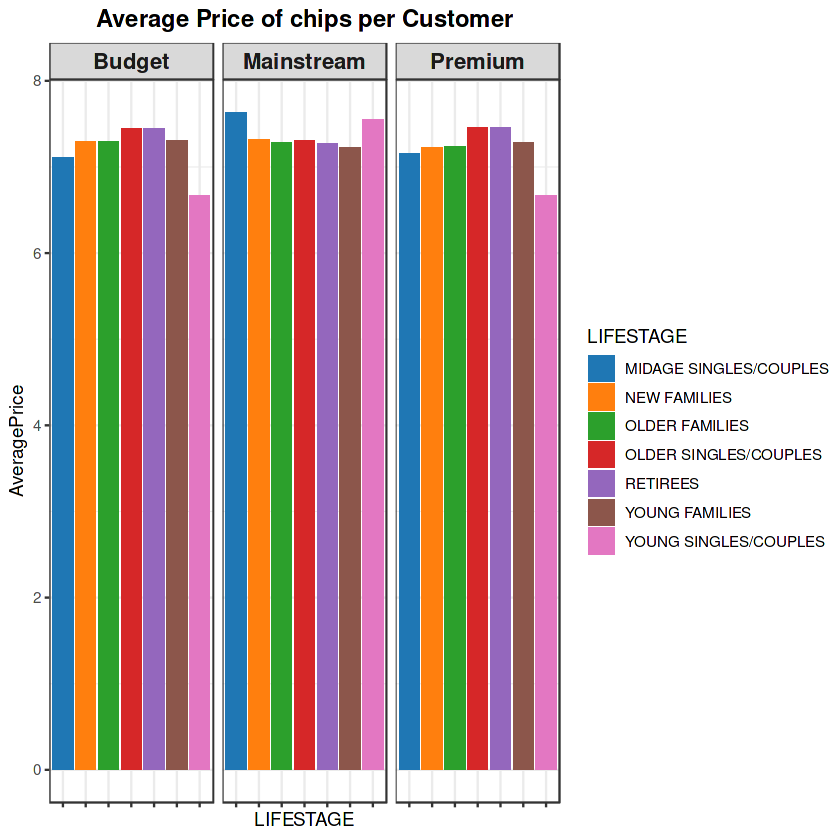

In [90]:
ggplot(AveragePrice,aes(x=LIFESTAGE,y=AveragePrice,fill=LIFESTAGE))+
geom_col()+
facet_wrap(~PREMIUM_CUSTOMER)+
scale_y_continuous(labels=scales::label_comma())+
theme(  plot.title=element_text(size=14,face= "bold",hjust=0.5),
     strip.text=element_text(size = 13, face = "bold"),
    axis.text.x=element_blank()) + 
scale_fill_manual(values = c(
    "MIDAGE SINGLES/COUPLES" = "#1f77b4",
    "NEW FAMILIES" = "#ff7f0e",
    "OLDER FAMILIES" = "#2ca02c",
    "OLDER SINGLES/COUPLES" = "#d62728",
    "RETIREES" = "#9467bd",
    "YOUNG FAMILIES" = "#8c564b",
    "YOUNG SINGLES/COUPLES" = "#e377c2"
  )) +
labs(title= "Average Price of chips per Customer")

In [91]:
## Filtering the data to do the T-test
Mainstream <-  AveragePrice %>%
filter(PREMIUM_CUSTOMER == "Mainstream",
       LIFESTAGE %in% c("MIDAGE SINGLES/COUPLES","YOUNG SINGLES/COUPLES"))

Premium.Budget <- AveragePrice %>%
filter(PREMIUM_CUSTOMER %in% c("Budget","Premium"),
       LIFESTAGE %in% c("MIDAGE SINGLES/COUPLES","YOUNG SINGLES/COUPLES") )

In [92]:
t.test(Mainstream$AveragePrice, Premium.Budget$AveragePrice)



	Welch Two Sample t-test

data:  Mainstream$AveragePrice and Premium.Budget$AveragePrice
t = 4.947, df = 3.5375, p-value = 0.01062
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.2839471 1.1059075
sample estimates:
mean of x mean of y 
 7.594218  6.899290 


#### Conclusion from the T-test

1. There is a significant difference in the average price paid between the groups (p ≈ 0.01 < 0.05).

2. On average, Mainstream customers pay more for chips than the other group — about 0.7 units more.

3. The 95% confidence interval suggests this difference is not due to random chance.

In [93]:
head(Data)

LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES,Pack_Size,product_name,Brand,LIFESTAGE,PREMIUM_CUSTOMER
<int>,<date>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1000,2018-10-17,1,1,5,2,6.0,175,Natural Chip Compny SeaSalt,Natural,YOUNG SINGLES/COUPLES,Premium
1002,2018-09-16,1,2,58,1,2.7,150,Red Rock Deli Chikn&Garlic Aioli,Red,YOUNG SINGLES/COUPLES,Mainstream
1003,2019-03-07,1,3,52,1,3.6,210,Grain Waves Sour Cream&Chives 210G,Grain,YOUNG FAMILIES,Budget
1003,2019-03-08,1,4,106,1,3.0,175,Natural ChipCo Hony Soy Chckn,Natural,YOUNG FAMILIES,Budget
1004,2018-11-02,1,5,96,1,1.9,160,WW Original Stacked Chips,WW,OLDER SINGLES/COUPLES,Mainstream
1005,2018-12-28,1,6,86,1,2.8,165,Cheetos Puffs,Cheetos,MIDAGE SINGLES/COUPLES,Mainstream


### Diving into Mainstream, young singles/couples 
Using affinity index to figure out:
1. If there are brands that these two customer segments prefer more than others.
2. Preferred pack size compared to the rest of the population

In [99]:
SegmentBrandCount <- Data%>%
filter(PREMIUM_CUSTOMER == "Mainstream",
       LIFESTAGE =="YOUNG SINGLES/COUPLES")%>%
count(Brand, name = "Segment_Brand_Count",sort=TRUE)


In [95]:
TotalBrandCounts <- Data %>%
count(Brand,name="Total_Brand_Count",sort=TRUE)

In [100]:
##Calculate share and Affinity Index

BrandAffinity <- SegmentBrandCount %>%
inner_join(TotalBrandCounts,by="Brand") %>%
mutate(
    Segment_Share=Segment_Brand_Count/sum(Segment_Brand_Count),
    Total_Share=Total_Brand_Count/sum(Total_Brand_Count),
     Affinity_Index = Segment_Share / Total_Share
  ) %>%
  arrange(desc(Affinity_Index)) 
View(BrandAffinity)

Brand,Segment_Brand_Count,Total_Brand_Count,Segment_Share,Total_Share,Affinity_Index
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
Tyrrells,619,6442,0.031672124,0.026108454,1.2130984
Twisties,900,9454,0.046049939,0.038315636,1.2018576
Doritos,2379,25224,0.121725338,0.102229067,1.1907116
Tostitos,890,9471,0.045538273,0.038384534,1.1863703
Kettle,3844,41288,0.196684404,0.167334036,1.1753999
Pringles,2315,25102,0.118450675,0.101734619,1.1643104
Grain,576,6272,0.029471961,0.025419470,1.1594247
Cobs,864,9693,0.044207941,0.039284267,1.1253345
Infuzions,1250,14201,0.063958248,0.057554511,1.1112639


### Conclusion from the Brand affinity index:

> 1.0 → The segment likes the brand more than average

< 1.0 → The segment buys it less than average

The top five brands Mainstream, young/single couples prefer more are:
1. Tyrrells
2. Twisties
3. Doritos
4. Tostitos
5. Kettle

In [98]:
## Calculating affinity for pack size
SegmentPackCount <- Data%>%
filter(PREMIUM_CUSTOMER == "Mainstream",
       LIFESTAGE =="YOUNG SINGLES/COUPLES")%>%
count(Pack_Size, name= "Segment_Pack_Count",sort=TRUE)

In [101]:
TotalPackCount <- Data%>%
count(Pack_Size, name= "Total_Pack_Count",sort=TRUE)

In [105]:
PackSize_Affinity <- SegmentPackCount %>%
inner_join(TotalPackCount, by= "Pack_Size") %>%
mutate(
    Segment_Share=Segment_Pack_Count/sum(Segment_Pack_Count),
    Total_Share= Total_Pack_Count/sum(Total_Pack_Count),
    Affinity_index= Segment_Share/Total_Share
) %>%
arrange(desc(Affinity_index))
View(PackSize_Affinity)

LIFESTAGE,Pack_Size,Segment_Pack_Count,Total_Pack_Count,Segment_Share,Total_Share,Affinity_index
<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>
YOUNG SINGLES/COUPLES,270,620,6285,0.031723291,0.025472157,1.2454105
YOUNG SINGLES/COUPLES,380,626,6416,0.032030291,0.026003080,1.2317883
YOUNG SINGLES/COUPLES,330,1195,12540,0.061144085,0.050822728,1.2030855
YOUNG SINGLES/COUPLES,134,2315,25102,0.118450675,0.101734619,1.1643104
YOUNG SINGLES/COUPLES,210,576,6272,0.029471961,0.025419470,1.1594247
YOUNG SINGLES/COUPLES,110,2051,22387,0.104942693,0.090731134,1.1566338
YOUNG SINGLES/COUPLES,135,290,3257,0.014838314,0.013200130,1.1241036
YOUNG SINGLES/COUPLES,250,280,3169,0.014326648,0.012843479,1.1154803
YOUNG SINGLES/COUPLES,170,1575,19983,0.080587393,0.080988085,0.9950525


### Concusion from Pack Size Affinity Index

The Mainstream, young/single couples have a preference for biggest pack sizes, while there's a tendency to avoid smaller pack sizes.  